In [8]:
package 'jdehart_SimplePartsModel' {
    package 'Fake Library' {
        part def Part;
        port def Port;
        connection def Connection;
    }

    part 'Power Group' : 'Fake Library'::Part {
        part 'Power Source' : 'Fake Library'::Part {
            port 'Power Out' : 'Fake Library'::Port;
        }
        part 'Power User' : 'Fake Library'::Part {
            port 'Power In' : 'Fake Library'::Port;
        }

        connection powerToUser : 'Fake Library'::Connection connect 'Power Source'::'Power Out' to 'Power User'::'Power In';
    }

}

Package jdehart_SimplePartsModel (10eb025a-f3da-4140-a0e8-80a33be8b734)


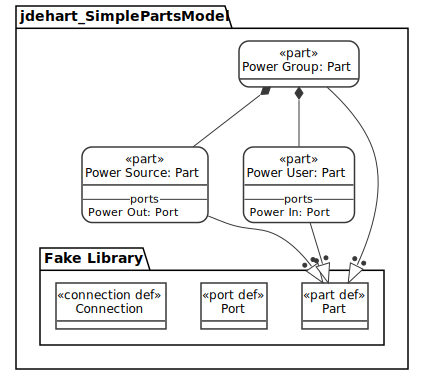

In [9]:
%viz "jdehart_SimplePartsModel"

In [13]:
#%publish "jdehart_SimplePartsModel"

In [54]:
# from pymbe playbook explorer
from pathlib import Path
import networkx as nx

import pymbe.api as pm

from pymbe.client import SysML2Client
from pymbe.graph.lpg import SysML2LabeledPropertyGraph
from pymbe.interpretation.interp_playbooks import (
    build_expression_sequence_templates,
    build_sequence_templates,
    random_generator_playbook,
)
from pymbe.interpretation.results import *
from pymbe.label import get_label_for_id
from pymbe.query.metamodel_navigator import feature_multiplicity
from pymbe.query.query import (
    roll_up_multiplicity,
    roll_up_upper_multiplicity,
    roll_up_multiplicity_for_type,
    get_types_for_feature,
    get_features_typed_by_type,
)
from pymbe.local.stablization import build_stable_id_lookups

In [55]:
helper_client = SysML2Client()

simple_parts_file = Path("") / "model.json"

helper_client._load_from_file(simple_parts_file)

In [56]:
lpg = SysML2LabeledPropertyGraph()
lpg.model = helper_client.model
shorten_pre_bake = {}

In [57]:
SIMPLE_MODEL = "Model::jdehart_SimplePartsModel::"
PARTS_LIBRARY = "Model::jdehart_SimplePartsModel::Fake Library::"

name_to_id_lookup = build_stable_id_lookups(lpg)[1]
name_to_id_lookup

connection_id = name_to_id_lookup[f"{PARTS_LIBRARY}Connection <<ConnectionDefinition>>"]
power_source_id = name_to_id_lookup[f"{SIMPLE_MODEL}Power Group: Part::Power Source: Part <<PartUsage>>"]
power_user_id = name_to_id_lookup[f"{SIMPLE_MODEL}Power Group: Part::Power User: Part <<PartUsage>>"]
part_id = name_to_id_lookup[f"{PARTS_LIBRARY}Part <<PartDefinition>>"]
power_in_id = name_to_id_lookup[f"{SIMPLE_MODEL}Power Group: Part::Power User: Part::Power In: Port <<PortUsage>>"]
connect_use_id = name_to_id_lookup[f"{SIMPLE_MODEL}Power Group: Part::powerToUser: Connection <<ConnectionUsage>>"]
power_group_id = name_to_id_lookup[f"{SIMPLE_MODEL}Power Group: Part::powerToUser: Connection <<ConnectionUsage>>"]

These edge types are not in the graph: {'ResultExpressionMembership', 'ParameterMembership'}.
These edge types are not in the graph: {'ImpliedReferentFeed', 'ReturnParameterMembership', 'Redefinition', 'ImpliedPathArgumentFeedforward', 'ImpliedParameterFeedforward'}.


In [58]:
from pymbe.query.query import get_types_for_feature, get_features_typed_by_type, roll_up_multiplicity_for_type

In [59]:
m0_interpretation = random_generator_playbook(
    lpg,
    shorten_pre_bake,
)

These edge types are not in the graph: {'Superclassing'}.
These node types are not in the graph: {'ReferenceUsage'}.
These edge types are not in the graph: {'FeatureValue', 'ReturnParameterMembership', 'ParameterMembership'}.


In [60]:
for print_line in pprint_interpretation(m0_interpretation, lpg.model):
    print(print_line)

Connection, id = d589b69a-92b1-4179-973c-aea1dbd9e2a6, size = 1
[Connection#0]
Part, id = c7d26e2c-c288-4115-8e8a-cbf065134355, size = 3
[Part#0]
[Part#1]
[Part#2]
Port, id = 1c745816-847a-4e63-8a7f-3e7d336d0fe4, size = 2
[Port#0]
[Port#1]
Power Group: Part, id = 1a75db52-3597-40d8-9879-67f76d0b1db9, size = 1
[Part#0]
Power Source: Part, id = f29848a9-ba29-479c-9f28-976387ee52ae, size = 1
[Part#0, Part#1]
Power Out: Port, id = 4f69a994-8460-470b-b886-5af81c8c24f6, size = 1
[Part#0, Part#1, Port#0]
powerToUser: Connection, id = 28399c55-100d-4f91-96f7-3c2be3a67dd7, size = 1
[Part#0, Connection#0]
Power User: Part, id = 0a2cca58-06b2-4f3e-b7f8-d69a7f48e4e0, size = 1
[Part#0, Part#2]
Power In: Port, id = bed6a577-00b9-4158-ab51-31d2a0c6474a, size = 1
[Part#0, Part#2, Port#1]
1ce96367-7138-4982-9d0f-47567d1c083c «Feature», id = 1ce96367-7138-4982-9d0f-47567d1c083c, size = 1
[Part#0, Connection#0, Part#1, Port#0]
f2d73272-377e-4dc4-b54b-e618873d0584 «Feature», id = f2d73272-377e-4dc4-b54b-e

In [61]:
from pprint import pprint
from collections import defaultdict


connector_usagetypes = ("ConnectionUsage", "SuccessionUsage")
elements = lpg.model.elements

connectors, m1_connectors = [], []
for id_, sequences in m0_interpretation.items():
    element = elements[id_]
    if element["@type"] in connector_usagetypes:
        connectors += [connector_usage for *_, connector_usage in sequences]
        src, tgt = element["connectorEnd"][:2]
        src, tgt = src["@id"], tgt["@id"]
        m1_connectors += [(element["@id"], src, tgt)]

to_parent = {}
for id_, sequences in m0_interpretation.items():
    element = elements[id_]
    if element["@type"] in ("PartUsage", "PortUsage"):
        for sequence in sequences:
            parent = sequence[0]
            for child in sequence[1:]:
                to_parent[child] = parent
                parent = child
    
pprint(dict(to_parent))

{Port#1: Part#2, Part#2: Part#0, Port#0: Part#1, Part#1: Part#0}


In [62]:
m0_connectors = []
for conn_usage, src, tgt in m1_connectors:
    for m0_conn_usage in m0_interpretation[conn_usage._id]:
        num_items = len(m0_conn_usage)
        for m0_src in m0_interpretation[src._id]:
            if m0_src[:num_items] == m0_conn_usage:
                m0_src = m0_src[-1]
                break
        for m0_tgt in m0_interpretation[tgt._id]:
            if m0_tgt[:num_items] == m0_conn_usage:
                m0_tgt = m0_tgt[-1]
                break
        m0_connectors += [(tuple(m0_conn_usage), m0_src, m0_tgt)]
m0_connectors

[((Part#0, Connection#0), Port#0, Port#1)]

In [63]:
import ipywidgets as ipyw
from pymbe.widget.diagram.parts import Part
from pymbe.widget.diagram.part_diagram import PartDiagram
from pymbe.widget.diagram.relationships import Relationship

import ipyelk as IE

from ipyelk.elements import Compartment, Edge, Label, Node, Port, NodeShape, NodeProperties
from ipyelk.elements.shapes import Widget

In [64]:
m0_connectors

[((Part#0, Connection#0), Port#0, Port#1)]

In [65]:
diagram = IE.Diagram(layout={"height": "100%"})
diagram

Diagram(children=[HTML(value='<style></style>', layout=Layout(display='None')), SprottyViewer(hover=Hover(tee=…

In [21]:
parts = {
    instance: Node(
        layoutOptions={
            "org.eclipse.elk.portLabels.placement": "INSIDE",
            "org.eclipse.elk.nodeSize.constraints": "NODE_LABELS PORTS PORT_LABELS MINIMUM_SIZE",
            "org.eclipse.elk.nodeLabels.placement": "H_CENTER V_CENTER",
        },
        labels=[
            Label(text=instance.name)
            # for part in (instance.name.split("#")[0], instance.name)
        ],
        # Leaving the commented out code for future reference
#         properties=NodeProperties(shape=Widget(
#             widget=ipyw.Text(),
#             width=200,
#             height=100,
#         )),
    )
    for instance in set([*to_parent, *to_parent.values()])
}

In [22]:
part_diagram = PartDiagram()

compartments = {}
ports = {}


for instance, part in parts.items():
    parent = parts.get(to_parent.get(instance, None), None)
    if parent is None:
        part_diagram.add_child(part)
        continue
    if instance.name.startswith("Port"):
        ports[instance] = parent.add_port(
            Port(
                labels=[Label(
                    text=instance.name, #.split("#")[-1],
                )],
                layoutOptions={
                    "org.eclipse.elk.port.borderOffset": "-15"
                },
                height=15,
                width=15,
            )
        )
    else:
        if not hasattr(parent, "parts"):
            parent.parts = Node()
        parent.parts.add_child(part)

In [23]:
self_edges = []
for connector, src, tgt in m0_connectors:
    edge = parent.add_edge(source=ports[src], target=ports[tgt])
    if ports[src].get_parent() == ports[tgt].get_parent():
        self_edges.append(edge)

In [24]:
loader = IE.ElementLoader()
diagram.source = loader.load(part_diagram)
diagram.style = part_diagram.style
diagram.view.symbols = part_diagram.symbols

In [25]:
[edge.id for edge in self_edges]

[]

In [26]:
val = diagram.pipe.pipes[0]
val.errors

{}